# Wine GGH Expansion Benchmark (Cleaned)

This notebook contains only the necessary code to run the GGH expansion benchmark.

**Results**: Partial R2 ≈ 0.18, GGH R2 ≈ 0.235


In [16]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators, compute_individual_grads_nothread
from GGH.models import initialize_model, load_model
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, visualize_train_val_error, selection_histograms
from GGH.custom_optimizer import CustomAdam
from sklearn.metrics import r2_score
from torch.autograd import grad
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def set_to_deterministic(rand_state):
    import random
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)
    torch.set_num_threads(1)
    torch.use_deterministic_algorithms(True)

print("Imports successful!")

Imports successful!


In [17]:
# Data configuration
data_path = '../data/wine/red_wine.csv'
results_path = "../saved_results/Red Wine Hybrid Iterative"
inpt_vars = ['volatile acidity', 'total sulfur dioxide', 'citric acid'] 
target_vars = ['quality']
miss_vars = ['alcohol']

# Hypothesis values (3-class)
hypothesis = [[9.4, 10.5, 12.0]]

# Model parameters
hidden_size = 32
output_size = len(target_vars)
hyp_per_sample = len(hypothesis[0])
batch_size = 100 * hyp_per_sample

# Training parameters
partial_perc = 0.025  # 2.5% complete data
rand_state = 1
lr = 0.001

# Iteration 1 parameters
iter1_epochs = 60
iter1_analysis_epochs = 5  # Track last 5 epochs

# Iteration 2 parameters
iter2_epochs = 30  # Same training duration
top_percentile = 30  # Use top 30% from Iteration 1
partial_target_ratio = 0.25  # Partial should be ~25% of effective training

# Iteration 3 parameters
iter3_analysis_epochs = 5  # Track last 5 epochs for remaining data

# Create directories
import os
os.makedirs(results_path, exist_ok=True)
for folder in ['iteration1', 'iteration2', 'iteration3']:
    os.makedirs(f'{results_path}/{folder}', exist_ok=True)

print(f"Results will be saved to: {results_path}")
print(f"Iteration 1: {iter1_epochs} epochs (track last {iter1_analysis_epochs})")
print(f"Iteration 2: {iter2_epochs} epochs on top {top_percentile}% + weighted partial")
print(f"Iteration 3: Score remaining {100-top_percentile}% with biased model")
print(f"Hypothesis values: {hypothesis[0]}")

Results will be saved to: ../saved_results/Red Wine Hybrid Iterative
Iteration 1: 60 epochs (track last 5)
Iteration 2: 30 epochs on top 30% + weighted partial
Iteration 3: Score remaining 70% with biased model
Hypothesis values: [9.4, 10.5, 12.0]


## Model Definitions

In [18]:
class HypothesisAmplifyingModel(nn.Module):
    """
    Neural network that amplifies the impact of hypothesis feature on gradients.
    
    Architecture:
    - Shared features (non-hypothesis): small embedding
    - Hypothesis feature: separate, larger embedding path
    - Concatenate and process through final layers
    """
    def __init__(self, n_shared_features, n_hypothesis_features=1, 
                 shared_hidden=16, hypothesis_hidden=32, final_hidden=32, output_size=1):
        super().__init__()
        
        # Shared features path (smaller)
        self.shared_path = nn.Sequential(
            nn.Linear(n_shared_features, shared_hidden),
            nn.ReLU(),
        )
        
        # Hypothesis feature path (larger - amplifies its importance)
        self.hypothesis_path = nn.Sequential(
            nn.Linear(n_hypothesis_features, hypothesis_hidden),
            nn.ReLU(),
            nn.Linear(hypothesis_hidden, hypothesis_hidden),
            nn.ReLU(),
        )
        
        # Combined path
        combined_size = shared_hidden + hypothesis_hidden
        self.final_path = nn.Sequential(
            nn.Linear(combined_size, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, output_size)
        )
        
        self.n_shared = n_shared_features
        
    def forward(self, x):
        # Split input: shared features vs hypothesis feature
        shared_features = x[:, :self.n_shared]
        hypothesis_feature = x[:, self.n_shared:]
        
        # Process separately
        shared_emb = self.shared_path(shared_features)
        hypothesis_emb = self.hypothesis_path(hypothesis_feature)
        
        # Combine and predict
        combined = torch.cat([shared_emb, hypothesis_emb], dim=1)
        return self.final_path(combined)


class StandardModel(nn.Module):
    """Standard MLP for comparison."""
    def __init__(self, input_size, hidden_size=32, output_size=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.net(x)

print("Models defined.")

Models defined.


## Training Classes

In [19]:
class UnbiasedTrainer:
    """
    Train on ALL hypotheses equally (no selection).
    Track per-hypothesis losses and gradients in the last N epochs.
    Used for Iteration 1.
    """
    def __init__(self, DO, model, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        # Tracking data
        self.loss_history = {}  # global_id -> list of losses per epoch
        self.gradient_history = {}  # global_id -> list of gradient vectors
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on ALL hypotheses equally."""
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Standard forward pass on ALL hypotheses
            predictions = self.model(inputs)
            
            # Compute loss (mean over all hypotheses - no selection)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            batch_loss = individual_losses.mean()
            
            # Track per-hypothesis data if in analysis window
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Standard backprop on ALL hypotheses
            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            
            total_loss += batch_loss.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient for this hypothesis
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            # Get gradient w.r.t. last layer weights
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results for each hypothesis."""
        analysis = {}
        
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        
        return analysis

print("UnbiasedTrainer defined.")

UnbiasedTrainer defined.


In [20]:
class BiasedTrainer:
    """
    Train on selected hypotheses + weighted partial data.
    Used for Iteration 2.
    """
    def __init__(self, DO, model, selected_gids, partial_gids, partial_weight, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        self.selected_gids = set(selected_gids)  # Top N% from Iteration 1
        self.partial_gids = set(partial_gids)    # Partial data (known correct)
        self.partial_weight = partial_weight
        
        # Tracking data for analysis
        self.loss_history = {}
        self.gradient_history = {}
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on selected + partial data."""
        self.model.train()
        total_loss = 0
        total_weight = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Compute individual losses
            predictions = self.model(inputs)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            
            # Apply weights: selected gets weight 1, partial gets partial_weight
            weights = torch.zeros(len(inputs), device=self.device)
            included_indices = []
            
            for i, gid in enumerate(global_ids):
                gid = gid.item()
                if gid in self.partial_gids:
                    weights[i] = self.partial_weight
                    included_indices.append(i)
                elif gid in self.selected_gids:
                    weights[i] = 1.0
                    included_indices.append(i)
            
            if len(included_indices) == 0:
                continue
            
            # Weighted loss
            weighted_loss = (individual_losses * weights).sum() / weights.sum()
            
            # Track data if requested
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Backprop
            self.optimizer.zero_grad()
            weighted_loss.backward()
            self.optimizer.step()
            
            total_loss += weighted_loss.item() * weights.sum().item()
            total_weight += weights.sum().item()
        
        return total_loss / total_weight if total_weight > 0 else 0
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results."""
        analysis = {}
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis

print("BiasedTrainer defined.")

BiasedTrainer defined.


In [21]:
class RemainingDataScorer:
    """
    Score remaining data (not used in Iteration 2) using a biased model.
    Computes both loss and gradient signals.
    Used for Iteration 3.
    """
    def __init__(self, DO, model, remaining_sample_indices, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.hyp_per_sample = DO.num_hyp_comb
        self.remaining_sample_indices = set(remaining_sample_indices)
        
        # Storage for scores
        self.loss_scores = {}  # gid -> avg_loss
        self.gradient_history = {}  # gid -> list of gradients
        
    def compute_scores(self, dataloader, n_passes=5):
        """
        Compute loss and gradient scores for remaining data.
        Run multiple passes to get stable gradient estimates.
        """
        self.model.eval()
        criterion = nn.MSELoss(reduction='none')
        
        for pass_idx in tqdm(range(n_passes), desc="Scoring passes"):
            for inputs, targets, global_ids in dataloader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                for i in range(len(inputs)):
                    gid = global_ids[i].item()
                    sample_idx = gid // self.hyp_per_sample
                    
                    # Only score remaining samples
                    if sample_idx not in self.remaining_sample_indices:
                        continue
                    
                    # Compute loss
                    inp = inputs[i:i+1].clone().requires_grad_(True)
                    pred = self.model(inp)
                    loss = nn.MSELoss()(pred, targets[i:i+1])
                    
                    # Store loss
                    if gid not in self.loss_scores:
                        self.loss_scores[gid] = []
                    self.loss_scores[gid].append(loss.item())
                    
                    # Compute gradient
                    params = list(self.model.parameters())
                    grad_param = grad(loss, params[-2], retain_graph=False)[0]
                    grad_vec = grad_param.flatten().detach().cpu().numpy()
                    
                    if gid not in self.gradient_history:
                        self.gradient_history[gid] = []
                    self.gradient_history[gid].append(grad_vec)
        
        print(f"Scored {len(self.loss_scores)} hypotheses from {len(self.remaining_sample_indices)} samples")
    
    def get_analysis(self):
        """Get analysis for scored hypotheses."""
        analysis = {}
        for gid in self.loss_scores:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_scores[gid]),
                'loss_std': np.std(self.loss_scores[gid]),
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis

print("RemainingDataScorer defined.")

RemainingDataScorer defined.


## Utilities

In [22]:
def compute_anchor_data(trainer, DO):
    """
    Compute gradient-only anchors AND enriched anchors for each class.
    Also computes anchor_similarity to decide which method to use per class.
    """
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Compute all anchors per class
    anchor_correct_grad = {}
    anchor_incorrect_grad = {}
    anchor_correct_enriched = {}
    anchor_incorrect_enriched = {}
    anchor_similarity_grad = {}
    anchor_similarity_enriched = {}
    use_enriched = {}
    
    # For normalization: collect all gradients to get scale
    all_grads = [analysis[gid]['avg_gradient'] for gid in analysis 
                 if analysis[gid]['avg_gradient'] is not None]
    grad_scale = float(np.mean([np.linalg.norm(g) for g in all_grads])) if all_grads else 1.0
    
    # Store normalization params per class
    feature_norm_params = {}
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        # Collect gradients and features for correct
        correct_grads = []
        correct_features = []
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                correct_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                correct_features.append(feat)
        
        # Collect gradients and features for incorrect
        incorrect_grads = []
        incorrect_features = []
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                incorrect_features.append(feat)
        
        if not correct_grads or not incorrect_grads:
            continue
            
        # Gradient-only anchors
        anchor_correct_grad[class_id] = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad[class_id] = np.mean(incorrect_grads, axis=0)
        
        # Compute gradient-only anchor similarity
        sim_grad = float(np.dot(anchor_correct_grad[class_id], anchor_incorrect_grad[class_id]) / (
            np.linalg.norm(anchor_correct_grad[class_id]) * np.linalg.norm(anchor_incorrect_grad[class_id]) + 1e-8))
        anchor_similarity_grad[class_id] = sim_grad
        
        # Decide: use enriched if gradient anchor_similarity > 0
        use_enriched[class_id] = sim_grad > 0
        
        # Enriched anchors (gradient + normalized features)
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        
        # Normalize features to gradient scale
        all_features = np.vstack([correct_features, incorrect_features])
        feat_mean = np.mean(all_features, axis=0)
        feat_std = np.std(all_features, axis=0) + 1e-8
        
        feature_norm_params[class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
        
        correct_features_norm = (correct_features - feat_mean) / feat_std * grad_scale
        incorrect_features_norm = (incorrect_features - feat_mean) / feat_std * grad_scale
        
        # Enriched = gradient + normalized features
        correct_enriched = np.hstack([correct_grads, correct_features_norm])
        incorrect_enriched = np.hstack([incorrect_grads, incorrect_features_norm])
        
        anchor_correct_enriched[class_id] = np.mean(correct_enriched, axis=0)
        anchor_incorrect_enriched[class_id] = np.mean(incorrect_enriched, axis=0)
        
        # Compute enriched anchor similarity
        sim_enriched = float(np.dot(anchor_correct_enriched[class_id], anchor_incorrect_enriched[class_id]) / (
            np.linalg.norm(anchor_correct_enriched[class_id]) * np.linalg.norm(anchor_incorrect_enriched[class_id]) + 1e-8))
        anchor_similarity_enriched[class_id] = sim_enriched
    
    return {
        'anchor_correct_grad': anchor_correct_grad,
        'anchor_incorrect_grad': anchor_incorrect_grad,
        'anchor_correct_enriched': anchor_correct_enriched,
        'anchor_incorrect_enriched': anchor_incorrect_enriched,
        'anchor_similarity_grad': anchor_similarity_grad,
        'anchor_similarity_enriched': anchor_similarity_enriched,
        'use_enriched': use_enriched,
        'grad_scale': grad_scale,
        'feature_norm_params': feature_norm_params,
        'partial_correct_gids': partial_correct_gids,
        'blacklisted_gids': blacklisted_gids,
        'partial_sample_indices': partial_sample_indices,
        'input_cols': input_cols
    }


def compute_adaptive_score(gradient, features, class_id, anchor_data):
    """
    Compute score using adaptive method:
    - Gradient-only for classes with good gradient separation (anchor_sim < 0)
    - Enriched (gradient + features) for classes with poor gradient separation (anchor_sim > 0)
    """
    use_enriched = anchor_data['use_enriched'].get(class_id, False)
    
    if use_enriched:
        # Use enriched vectors
        norm_params = anchor_data['feature_norm_params'].get(class_id)
        if norm_params:
            features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
        else:
            features_norm = features
        enriched = np.concatenate([gradient, features_norm])
        
        anchor_c = anchor_data['anchor_correct_enriched'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_enriched'].get(class_id)
    else:
        # Use gradient-only
        enriched = gradient
        anchor_c = anchor_data['anchor_correct_grad'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_grad'].get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    
    if anchor_i is not None:
        sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8))
    else:
        sim_i = 0.0
    
    return sim_c - sim_i


def print_adaptive_method_summary(anchor_data, hyp_per_sample):
    """Print summary of adaptive method selection per class."""
    print("Per-class method selection:")
    for class_id in range(hyp_per_sample):
        use_enr = anchor_data['use_enriched'].get(class_id, False)
        sim_grad = anchor_data['anchor_similarity_grad'].get(class_id, None)
        sim_enr = anchor_data['anchor_similarity_enriched'].get(class_id, None)
        
        if use_enr:
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (poor) -> ENRICHED (enriched_sim={sim_enr:+.3f})")
        else:
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (good) -> GRADIENT-ONLY")

print("Adaptive context utilities loaded.")

Adaptive context utilities loaded.


## GGH Expansion Benchmark

BENCHMARK: GGH Expansion (Enriched) vs Partial-Only
GGH Method (Expansion Strategy):
  Iter1: 60 epochs unbiased (lr=0.01), last 5 tracked
  Iter1: Enriched selection (gradient + features) -> top 30%
  Iter2: 30 epochs biased (lr=0.01, pw=2.0) on top 30% + partial
  Iter3: EXPANSION - Score REMAINING 70% with Enriched+Loss, select best
  Final: Train on expansion selection + partial (pw=2.0)
Partial: Train only on partial data (~2.5%)
Both: 200 epochs, validation-based epoch selection, same architecture

RUN 1/15 (rand_state=42)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.92it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 33.9%, class dist: {0: 51, 1: 105, 2: 180}
  Iter3 top 20% (of remaining) precision: 63.1%, class dist: {0: 101, 1: 56, 2: 0}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 43.2%, class dist: {0: 152, 1: 161, 2: 180}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=14, val_loss=0.0181, test_loss=0.0181, test_mae=0.0936, R2=0.3081
Training Partial model (200 epochs)...
Partial: best_epoch=41, val_loss=0.0176, test_loss=0.0172, test_mae=0.0982, R2=0.3394

>>> Improvement: Loss=-0.0008, MAE=+0.0046, R2=-0.0313

RUN 2/15 (rand_state=142)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.98it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 56.2%, class dist: {0: 120, 1: 17, 2: 199}
  Iter3 top 20% (of remaining) precision: 52.2%, class dist: {0: 91, 1: 66, 2: 0}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 55.0%, class dist: {0: 211, 1: 83, 2: 199}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=31, val_loss=0.0190, test_loss=0.0213, test_mae=0.1109, R2=0.1300
Training Partial model (200 epochs)...
Partial: best_epoch=4, val_loss=0.0179, test_loss=0.0194, test_mae=0.1102, R2=0.2048

>>> Improvement: Loss=-0.0018, MAE=-0.0007, R2=-0.0748

RUN 3/15 (rand_state=242)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.94it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 50.9%, class dist: {0: 68, 1: 0, 2: 268}
  Iter3 top 20% (of remaining) precision: 36.9%, class dist: {0: 46, 1: 111, 2: 0}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 46.5%, class dist: {0: 114, 1: 111, 2: 268}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=13, val_loss=0.0199, test_loss=0.0174, test_mae=0.1022, R2=0.2729
Training Partial model (200 epochs)...
Partial: best_epoch=88, val_loss=0.0196, test_loss=0.0171, test_mae=0.1036, R2=0.2850

>>> Improvement: Loss=-0.0003, MAE=+0.0015, R2=-0.0121

RUN 4/15 (rand_state=342)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.89it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 47.0%, class dist: {0: 85, 1: 183, 2: 68}
  Iter3 top 20% (of remaining) precision: 51.0%, class dist: {0: 43, 1: 114, 2: 0}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 48.3%, class dist: {0: 128, 1: 297, 2: 68}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=18, val_loss=0.0161, test_loss=0.0165, test_mae=0.0987, R2=0.2915
Training Partial model (200 epochs)...
Partial: best_epoch=97, val_loss=0.0210, test_loss=0.0187, test_mae=0.1101, R2=0.1972

>>> Improvement: Loss=+0.0022, MAE=+0.0114, R2=+0.0943

RUN 5/15 (rand_state=442)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.93it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 42.0%, class dist: {0: 71, 1: 161, 2: 104}
  Iter3 top 20% (of remaining) precision: 63.1%, class dist: {0: 137, 1: 5, 2: 15}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 48.7%, class dist: {0: 208, 1: 166, 2: 119}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=9, val_loss=0.0219, test_loss=0.0176, test_mae=0.1011, R2=0.2940
Training Partial model (200 epochs)...
Partial: best_epoch=10, val_loss=0.0244, test_loss=0.0203, test_mae=0.1061, R2=0.1838

>>> Improvement: Loss=+0.0027, MAE=+0.0051, R2=+0.1102

RUN 6/15 (rand_state=542)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.91it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 61.6%, class dist: {0: 141, 1: 31, 2: 164}
  Iter3 top 20% (of remaining) precision: 70.1%, class dist: {0: 130, 1: 27, 2: 0}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 64.3%, class dist: {0: 271, 1: 58, 2: 164}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=27, val_loss=0.0164, test_loss=0.0186, test_mae=0.1027, R2=0.2219
Training Partial model (200 epochs)...
Partial: best_epoch=52, val_loss=0.0174, test_loss=0.0194, test_mae=0.1114, R2=0.1901

>>> Improvement: Loss=+0.0008, MAE=+0.0086, R2=+0.0318

RUN 7/15 (rand_state=642)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.88it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 40.8%, class dist: {0: 82, 1: 147, 2: 107}
  Iter3 top 20% (of remaining) precision: 59.9%, class dist: {0: 71, 1: 58, 2: 28}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 46.9%, class dist: {0: 153, 1: 205, 2: 135}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=12, val_loss=0.0208, test_loss=0.0188, test_mae=0.1086, R2=0.2032
Training Partial model (200 epochs)...
Partial: best_epoch=5, val_loss=0.0233, test_loss=0.0210, test_mae=0.1154, R2=0.1099

>>> Improvement: Loss=+0.0022, MAE=+0.0068, R2=+0.0933

RUN 8/15 (rand_state=742)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.98it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 54.8%, class dist: {0: 121, 1: 31, 2: 184}
  Iter3 top 20% (of remaining) precision: 53.5%, class dist: {0: 80, 1: 77, 2: 0}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 54.4%, class dist: {0: 201, 1: 108, 2: 184}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=9, val_loss=0.0201, test_loss=0.0210, test_mae=0.1138, R2=0.1930
Training Partial model (200 epochs)...
Partial: best_epoch=41, val_loss=0.0192, test_loss=0.0185, test_mae=0.1102, R2=0.2889

>>> Improvement: Loss=-0.0025, MAE=-0.0036, R2=-0.0959

RUN 9/15 (rand_state=842)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.93it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 46.7%, class dist: {0: 66, 1: 156, 2: 114}
  Iter3 top 20% (of remaining) precision: 65.0%, class dist: {0: 81, 1: 28, 2: 48}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 52.5%, class dist: {0: 147, 1: 184, 2: 162}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=4, val_loss=0.0170, test_loss=0.0244, test_mae=0.1156, R2=0.2054
Training Partial model (200 epochs)...
Partial: best_epoch=14, val_loss=0.0159, test_loss=0.0244, test_mae=0.1217, R2=0.2050

>>> Improvement: Loss=+0.0000, MAE=+0.0061, R2=+0.0004

RUN 10/15 (rand_state=942)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.90it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 59.5%, class dist: {0: 246, 1: 90, 2: 0}
  Iter3 top 20% (of remaining) precision: 31.8%, class dist: {0: 19, 1: 132, 2: 6}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 50.7%, class dist: {0: 265, 1: 222, 2: 6}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=9, val_loss=0.0147, test_loss=0.0225, test_mae=0.1179, R2=0.2169
Training Partial model (200 epochs)...
Partial: best_epoch=6, val_loss=0.0169, test_loss=0.0240, test_mae=0.1214, R2=0.1681

>>> Improvement: Loss=+0.0014, MAE=+0.0035, R2=+0.0488

RUN 11/15 (rand_state=1042)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.98it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 54.2%, class dist: {0: 170, 1: 12, 2: 154}
  Iter3 top 20% (of remaining) precision: 35.7%, class dist: {0: 0, 1: 109, 2: 48}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 48.3%, class dist: {0: 170, 1: 121, 2: 202}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=167, val_loss=0.0198, test_loss=0.0204, test_mae=0.1168, R2=0.1502
Training Partial model (200 epochs)...
Partial: best_epoch=3, val_loss=0.0224, test_loss=0.0229, test_mae=0.1148, R2=0.0496

>>> Improvement: Loss=+0.0024, MAE=-0.0020, R2=+0.1006

RUN 12/15 (rand_state=1142)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.98it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 54.8%, class dist: {0: 167, 1: 88, 2: 81}
  Iter3 top 20% (of remaining) precision: 53.5%, class dist: {0: 36, 1: 121, 2: 0}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 54.4%, class dist: {0: 203, 1: 209, 2: 81}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=25, val_loss=0.0183, test_loss=0.0200, test_mae=0.1127, R2=0.1426
Training Partial model (200 epochs)...
Partial: best_epoch=86, val_loss=0.0199, test_loss=0.0228, test_mae=0.1204, R2=0.0234

>>> Improvement: Loss=+0.0028, MAE=+0.0077, R2=+0.1192

RUN 13/15 (rand_state=1242)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.94it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 52.4%, class dist: {0: 66, 1: 142, 2: 128}
  Iter3 top 20% (of remaining) precision: 54.1%, class dist: {0: 46, 1: 111, 2: 0}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 52.9%, class dist: {0: 112, 1: 253, 2: 128}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=43, val_loss=0.0197, test_loss=0.0184, test_mae=0.1064, R2=0.2548
Training Partial model (200 epochs)...
Partial: best_epoch=32, val_loss=0.0223, test_loss=0.0196, test_mae=0.1125, R2=0.2037

>>> Improvement: Loss=+0.0013, MAE=+0.0060, R2=+0.0512

RUN 14/15 (rand_state=1342)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.89it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 44.3%, class dist: {0: 174, 1: 121, 2: 41}
  Iter3 top 20% (of remaining) precision: 59.9%, class dist: {0: 71, 1: 25, 2: 61}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 49.3%, class dist: {0: 245, 1: 146, 2: 102}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=40, val_loss=0.0178, test_loss=0.0154, test_mae=0.1036, R2=0.3251
Training Partial model (200 epochs)...
Partial: best_epoch=192, val_loss=0.0241, test_loss=0.0240, test_mae=0.1330, R2=-0.0483

>>> Improvement: Loss=+0.0085, MAE=+0.0295, R2=+0.3734

RUN 15/15 (rand_state=1442)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 15.94it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 61.6%, class dist: {0: 211, 1: 125, 2: 0}
  Iter3 top 20% (of remaining) precision: 42.7%, class dist: {0: 3, 1: 72, 2: 82}
  Combined: 493 samples (336 iter1 + 157 iter3), precision: 55.6%, class dist: {0: 214, 1: 197, 2: 82}
  Dynamic partial_weight: 5.87
Training GGH model (200 epochs)...
GGH: best_epoch=15, val_loss=0.0171, test_loss=0.0166, test_mae=0.1055, R2=0.3601
Training Partial model (200 epochs)...
Partial: best_epoch=8, val_loss=0.0175, test_loss=0.0176, test_mae=0.1060, R2=0.3227

>>> Improvement: Loss=+0.0010, MAE=+0.0004, R2=+0.0375

BENCHMARK RESULTS: GGH Expansion (Enriched) vs Partial-Only

Detailed Results:
Run   GGH Prec   GGH Loss     Part Loss    Δ Loss     GGH R2     Part R2    Δ R2      
----------------------------------------------------------------------------------------------------
1     43.2      % 0.0181       0.0172          -0.0008 0.3081     0.3394        -0.0313
2     55.0      % 0.02

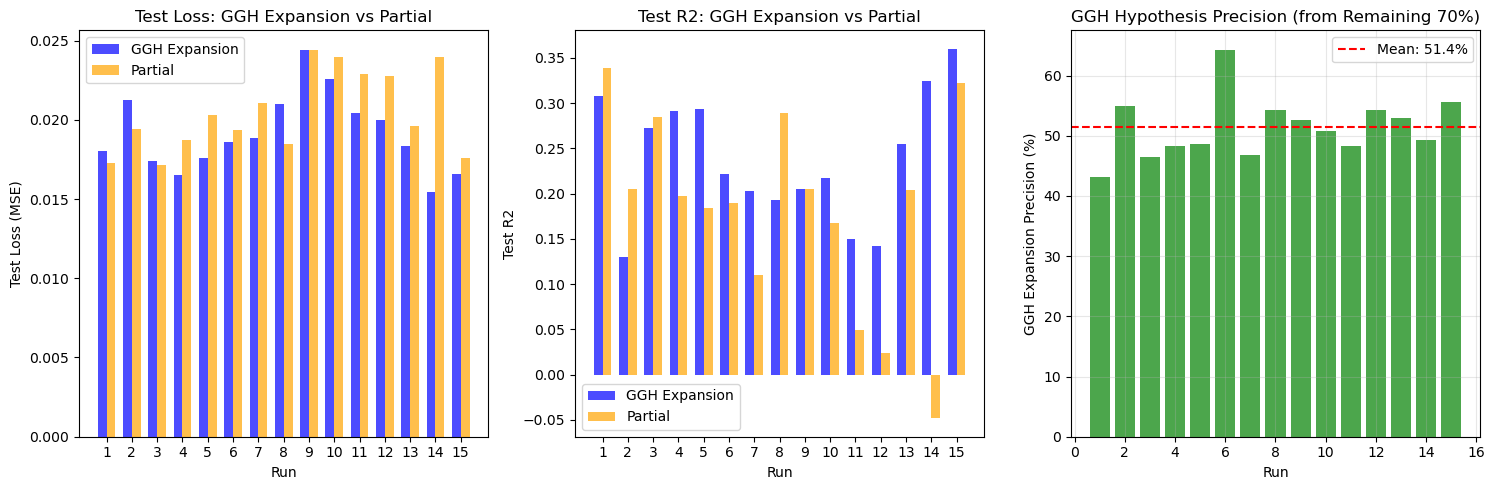


CONCLUSION
No significant difference in Loss (p=0.0661)
No significant difference in R2 (p=0.0666)


In [23]:
# =============================================================================
# BENCHMARK: GGH Expansion Strategy (Like Wine_Hybrid_Iterative) + Enriched Scoring
# =============================================================================
# GGH Method:
#   1. Unbiased training (60 epochs, last 5 tracked) + Enriched selection (top 30%)
#   2. Biased training (30 epochs, lr=0.01) on top 30% + partial
#   3. EXPANSION: Score REMAINING 70% with Enriched+Loss, select top from remaining
#   4. Final model trained on expansion selection + partial
# Partial: Only partial data (~2.5%)
# Both use same final model architecture, validation-based epoch selection
# =============================================================================
from scipy import stats
from torch.utils.data import TensorDataset, DataLoader

# === CONFIGURATION (Matching Wine_Hybrid_Iterative) ===
BENCHMARK_N_RUNS = 15
BENCHMARK_RAND_STATES = [42 + i * 100 for i in range(15)]
BENCHMARK_FINAL_EPOCHS = 200
BENCHMARK_LR = 0.01
BENCHMARK_PARTIAL_WEIGHT = 2.0  # Final model partial weight

# GGH Parameters (Matching Wine_Hybrid_Iterative)
GGH_ITER1_EPOCHS = 60              # 60 epochs (like Wine_Hybrid_Iterative)
GGH_ITER1_ANALYSIS_EPOCHS = 5      # Last 5 tracked (like Wine_Hybrid_Iterative)
GGH_ITER1_LR = 0.01                # lr=0.01 (like Wine_Hybrid_Iterative)
GGH_TOP_PERCENTILE = 30            # Top 30%
GGH_ITER2_EPOCHS = 30              # 30 epochs biased
GGH_ITER2_LR = 0.01                # lr=0.01 (like Wine_Hybrid_Iterative)
GGH_ITER2_PARTIAL_WEIGHT = 2.0     # partial_weight=2.0
GGH_SCORING_PASSES = 5             # 5 passes (like Wine_Hybrid_Iterative)
GGH_ITER3_TOP_PERCENTILE = 20      # Top 20% from remaining (unseen) samples

# Model architecture
MODEL_SHARED_HIDDEN = 16
MODEL_HYPOTHESIS_HIDDEN = 32
MODEL_FINAL_HIDDEN = 32


def create_dataloader_with_gids(DO, batch_size=32):
    """Create dataloader that includes global_ids."""
    input_cols = DO.inpt_vars + [var + '_hypothesis' for var in DO.miss_vars]
    n_samples = len(DO.df_train_hypothesis)
    global_ids = torch.arange(n_samples)
    
    dataset = TensorDataset(
        torch.tensor(DO.df_train_hypothesis[input_cols].values, dtype=torch.float32),
        torch.tensor(DO.df_train_hypothesis[DO.target_vars].values, dtype=torch.float32),
        global_ids
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def train_with_validation(DO, model, trainer_class, selected_gids, partial_gids, 
                          partial_weight, lr, n_epochs=200, batch_size=32):
    """Train model with validation-based epoch selection."""
    dataloader = create_dataloader_with_gids(DO, batch_size)
    
    trainer = trainer_class(DO, model, selected_gids=selected_gids, 
                           partial_gids=partial_gids, partial_weight=partial_weight, lr=lr)
    
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None
    
    for epoch in range(n_epochs):
        trainer.train_epoch(dataloader, epoch, track_data=False)
        
        model.eval()
        with torch.no_grad():
            val_inputs, val_targets = DO.get_validation_tensors(use_info="full info")
            val_preds = model(val_inputs)
            val_loss = torch.nn.functional.mse_loss(val_preds, val_targets).item()
        model.train()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
    
    model.load_state_dict(best_state)
    return model, best_epoch, best_val_loss


def evaluate_on_test(DO, model):
    """Evaluate model on test set. Returns loss, MAE, and R2 score."""
    model.eval()
    with torch.no_grad():
        test_inputs, test_targets = DO.get_test_tensors(use_info="full info")
        test_preds = model(test_inputs)
        test_loss = torch.nn.functional.mse_loss(test_preds, test_targets).item()
        test_mae = torch.nn.functional.l1_loss(test_preds, test_targets).item()
        
        ss_res = torch.sum((test_targets - test_preds) ** 2).item()
        ss_tot = torch.sum((test_targets - test_targets.mean()) ** 2).item()
        r2_score = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    return test_loss, test_mae, r2_score


def compute_enriched_score(gradient, features, class_id, anchor_data):
    """Compute enriched score (gradient + normalized features)."""
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        grad_scale = anchor_data.get('grad_scale', 1.0)
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    enriched = np.concatenate([gradient, features_norm])
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        anchor_c = anchor_data.get('anchor_correct_grad', {}).get(class_id)
        anchor_i = anchor_data.get('anchor_incorrect_grad', {}).get(class_id)
        enriched = gradient
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


def compute_enriched_score_with_loss(gradient, features, loss, class_id, anchor_data):
    """
    Compute enriched score with loss included (gradient + features + loss).
    For expansion scoring on remaining samples.
    """
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    loss_params = anchor_data.get('loss_norm_params', {}).get(class_id)
    grad_scale = anchor_data.get('grad_scale', 1.0)
    
    # Normalize features
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    # Normalize loss (negated: lower loss = higher value)
    if loss_params:
        loss_norm = -((loss - loss_params['mean']) / loss_params['std']) * loss_params['scale']
    else:
        loss_norm = -loss * grad_scale
    
    # Enriched = gradient + features + loss
    enriched = np.concatenate([gradient, features_norm, [loss_norm]])
    
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


def run_ggh_expansion(DO, rand_state):
    """
    Run GGH method with EXPANSION strategy (like Wine_Hybrid_Iterative) but with Enriched scoring.
    
    1. Unbiased training (60 epochs, track last 5) + Enriched selection -> top 30%
    2. Biased training on top 30% + partial (30 epochs)
    3. EXPANSION: Score REMAINING 70% with Enriched+Loss, select best from remaining
    
    Returns selected_gids, precision, partial_correct_gids
    """
    set_to_deterministic(rand_state)
    
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    n_shared = len(DO.inpt_vars)
    n_hyp = len(DO.miss_vars)
    out_size = len(DO.target_vars)
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    dataloader = create_dataloader_with_gids(DO, batch_size=32)
    
    # === ITERATION 1: Unbiased training (60 epochs, track last 5) + Enriched selection ===
    model_unbiased = HypothesisAmplifyingModel(n_shared, n_hyp, 
                                               MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN, 
                                               MODEL_FINAL_HIDDEN, out_size)
    trainer_unbiased = UnbiasedTrainer(DO, model_unbiased, lr=GGH_ITER1_LR)
    
    # Train without tracking for first (60-5)=55 epochs
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=False)
    
    # Track last 5 epochs
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS, GGH_ITER1_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=True)
    
    # Compute anchors for ENRICHED selection
    anchor_data = compute_anchor_data(trainer_unbiased, DO)
    analysis = trainer_unbiased.get_hypothesis_analysis()
    input_cols = anchor_data['input_cols']
    
    # Select using ENRICHED method (gradient + features)
    all_selections = []
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score, best_is_correct, best_gid, best_class = -np.inf, False, None, None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids or gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            # ENRICHED scoring (gradient + features)
            score = compute_enriched_score(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
                best_gid = gid
                best_class = class_id
        
        if best_score > -np.inf:
            all_selections.append((best_score, best_is_correct, sample_idx, best_gid, best_class))
    
    # Sort and get top 30%
    all_selections.sort(key=lambda x: x[0], reverse=True)
    n_top = int(len(all_selections) * GGH_TOP_PERCENTILE / 100)
    top_selections = all_selections[:n_top]
    top_sample_indices = set(s[2] for s in top_selections)
    sample_to_gid = {s[2]: s[3] for s in all_selections}
    
    # Iter1 precision
    iter1_correct = sum(1 for s in top_selections if s[1])
    iter1_precision = iter1_correct / len(top_selections) * 100 if top_selections else 0
    
    # Track iter1 class distribution
    iter1_class_counts = {c: 0 for c in range(hyp_per_sample)}
    for s in top_selections:
        gid = s[3]
        class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
        iter1_class_counts[class_id] += 1
    
    # === ITERATION 2: Biased training on top 30% + partial ===
    set_to_deterministic(rand_state + 100)
    model_biased = HypothesisAmplifyingModel(n_shared, n_hyp,
                                             MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN,
                                             MODEL_FINAL_HIDDEN, out_size)
    
    top_gids_set = set(sample_to_gid[idx] for idx in top_sample_indices if idx in sample_to_gid)
    trainer_biased = BiasedTrainer(DO, model_biased, selected_gids=top_gids_set,
                                   partial_gids=partial_correct_gids, 
                                   partial_weight=GGH_ITER2_PARTIAL_WEIGHT, lr=GGH_ITER2_LR)
    
    for epoch in range(GGH_ITER2_EPOCHS):
        trainer_biased.train_epoch(dataloader, epoch, track_data=False)
    
    # === ITERATION 3: EXPANSION - Score REMAINING 70% with Enriched+Loss ===
    all_sample_indices = set(range(n_samples))
    remaining_sample_indices = all_sample_indices - top_sample_indices - partial_sample_indices
    
    # First, score partial data to build anchors with loss
    partial_scorer = RemainingDataScorer(DO, model_biased, partial_sample_indices)
    partial_scorer.compute_scores(dataloader, n_passes=GGH_SCORING_PASSES)
    partial_analysis = partial_scorer.get_analysis()
    
    # Build anchors with loss from partial data
    anchor_data_biased = {
        'anchor_correct_grad': {},
        'anchor_incorrect_grad': {},
        'anchor_correct_enriched': {},  # Will include loss
        'anchor_incorrect_enriched': {},
        'feature_norm_params': {},
        'loss_norm_params': {},
    }
    
    # Compute normalization parameters
    all_grads = [partial_analysis[gid]['avg_gradient'] for gid in partial_correct_gids | blacklisted_gids
                 if gid in partial_analysis and partial_analysis[gid]['avg_gradient'] is not None]
    grad_scale = np.mean([np.linalg.norm(g) for g in all_grads]) if all_grads else 1.0
    anchor_data_biased['grad_scale'] = grad_scale
    
    inpt_vars_list = DO.inpt_vars
    
    for class_id in range(hyp_per_sample):
        correct_grads, incorrect_grads = [], []
        correct_features, incorrect_features = [], []
        correct_losses, incorrect_losses = [], []
        
        for gid in partial_correct_gids:
            if gid in partial_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if partial_analysis[gid]['avg_gradient'] is not None:
                    correct_grads.append(partial_analysis[gid]['avg_gradient'])
                    correct_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
                    correct_losses.append(partial_analysis[gid]['avg_loss'])
        
        for gid in blacklisted_gids:
            if gid in partial_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if partial_analysis[gid]['avg_gradient'] is not None:
                    incorrect_grads.append(partial_analysis[gid]['avg_gradient'])
                    incorrect_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
                    incorrect_losses.append(partial_analysis[gid]['avg_loss'])
        
        if correct_grads and incorrect_grads:
            # Gradient anchors
            anchor_data_biased['anchor_correct_grad'][class_id] = np.mean(correct_grads, axis=0)
            anchor_data_biased['anchor_incorrect_grad'][class_id] = np.mean(incorrect_grads, axis=0)
            
            # Feature normalization
            all_features = correct_features + incorrect_features
            feat_mean = np.mean(all_features, axis=0)
            feat_std = np.std(all_features, axis=0) + 1e-8
            anchor_data_biased['feature_norm_params'][class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
            
            correct_features_norm = [(f - feat_mean) / feat_std * grad_scale for f in correct_features]
            incorrect_features_norm = [(f - feat_mean) / feat_std * grad_scale for f in incorrect_features]
            
            # Loss normalization
            all_losses = correct_losses + incorrect_losses
            loss_mean = np.mean(all_losses)
            loss_std = np.std(all_losses) + 1e-8
            anchor_data_biased['loss_norm_params'][class_id] = {'mean': loss_mean, 'std': loss_std, 'scale': grad_scale}
            
            correct_losses_norm = [-(l - loss_mean) / loss_std * grad_scale for l in correct_losses]
            incorrect_losses_norm = [-(l - loss_mean) / loss_std * grad_scale for l in incorrect_losses]
            
            # Enriched anchors = gradient + features + loss
            correct_enriched = [np.concatenate([g, f, [l]]) 
                               for g, f, l in zip(correct_grads, correct_features_norm, correct_losses_norm)]
            incorrect_enriched = [np.concatenate([g, f, [l]]) 
                                 for g, f, l in zip(incorrect_grads, incorrect_features_norm, incorrect_losses_norm)]
            
            anchor_data_biased['anchor_correct_enriched'][class_id] = np.mean(correct_enriched, axis=0)
            anchor_data_biased['anchor_incorrect_enriched'][class_id] = np.mean(incorrect_enriched, axis=0)
    
    # Score REMAINING 70%
    scorer = RemainingDataScorer(DO, model_biased, remaining_sample_indices)
    scorer.compute_scores(dataloader, n_passes=GGH_SCORING_PASSES)
    remaining_analysis = scorer.get_analysis()
    
    # Score each hypothesis in remaining samples using Enriched+Loss
    remaining_scored = []
    for sample_idx in remaining_sample_indices:
        start_gid = sample_idx * hyp_per_sample
        best_score = -np.inf
        best_gid = None
        best_is_correct = False
        
        for hyp_idx in range(hyp_per_sample):
            gid = start_gid + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in remaining_analysis or remaining_analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = remaining_analysis[gid]['avg_gradient']
            loss = remaining_analysis[gid]['avg_loss']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64)
            
            # ENRICHED + LOSS scoring
            score = compute_enriched_score_with_loss(gradient, features, loss, class_id, anchor_data_biased)
            
            if score > best_score:
                best_score = score
                best_gid = gid
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        if best_gid is not None:
            remaining_scored.append({
                'sample_idx': sample_idx,
                'gid': best_gid,
                'score': best_score,
                'is_correct': best_is_correct
            })
    
    # Sort remaining by score and take top 20% (unseen from Iter1)
    remaining_scored.sort(key=lambda x: x['score'], reverse=True)
    n_take_from_remaining = int(len(remaining_scored) * GGH_ITER3_TOP_PERCENTILE / 100)
    top_remaining = remaining_scored[:n_take_from_remaining]
    
    # Calculate precision on top of remaining
    iter3_correct = sum(1 for s in top_remaining if s['is_correct'])
    iter3_precision = iter3_correct / len(top_remaining) * 100 if top_remaining else 0
    
    # Track iter3 class distribution
    iter3_class_counts = {c: 0 for c in range(hyp_per_sample)}
    for s in top_remaining:
        class_id = DO.df_train_hypothesis.iloc[s['gid']]['hyp_class_id']
        iter3_class_counts[class_id] += 1
    
    # COMBINE Iter1 + Iter3 selections
    iter1_gids = set(s[3] for s in top_selections)
    iter3_gids = set(s['gid'] for s in top_remaining)
    selected_gids = iter1_gids | iter3_gids
    
    # Calculate combined precision
    combined_correct = sum(1 for s in top_selections if s[1]) + iter3_correct
    combined_precision = combined_correct / len(selected_gids) * 100 if selected_gids else 0
    
    # Combined class distribution
    combined_class_counts = {c: 0 for c in range(hyp_per_sample)}
    for gid in selected_gids:
        class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
        combined_class_counts[class_id] += 1
    
    print(f"  Iter1 top {GGH_TOP_PERCENTILE}% precision: {iter1_precision:.1f}%, class dist: {iter1_class_counts}")
    print(f"  Iter3 top {GGH_ITER3_TOP_PERCENTILE}% (of remaining) precision: {iter3_precision:.1f}%, class dist: {iter3_class_counts}")
    print(f"  Combined: {len(selected_gids)} samples ({len(iter1_gids)} iter1 + {len(iter3_gids)} iter3), precision: {combined_precision:.1f}%, class dist: {combined_class_counts}")
    
    return selected_gids, combined_precision, partial_correct_gids, iter1_class_counts, iter3_class_counts, combined_class_counts


# =============================================================================
# MAIN COMPARISON LOOP
# =============================================================================
print("=" * 80)
print("BENCHMARK: GGH Expansion (Enriched) vs Partial-Only")
print("=" * 80)
print("GGH Method (Expansion Strategy):")
print(f"  Iter1: {GGH_ITER1_EPOCHS} epochs unbiased (lr={GGH_ITER1_LR}), last {GGH_ITER1_ANALYSIS_EPOCHS} tracked")
print(f"  Iter1: Enriched selection (gradient + features) -> top {GGH_TOP_PERCENTILE}%")
print(f"  Iter2: {GGH_ITER2_EPOCHS} epochs biased (lr={GGH_ITER2_LR}, pw={GGH_ITER2_PARTIAL_WEIGHT}) on top 30% + partial")
print(f"  Iter3: EXPANSION - Score REMAINING 70% with Enriched+Loss, select best")
print(f"  Final: Train on expansion selection + partial (pw={BENCHMARK_PARTIAL_WEIGHT})")
print(f"Partial: Train only on partial data (~2.5%)")
print(f"Both: {BENCHMARK_FINAL_EPOCHS} epochs, validation-based epoch selection, same architecture")
print("=" * 80)

results = []

for run_idx, run_rand_state in enumerate(BENCHMARK_RAND_STATES):
    print(f"\n{'='*60}")
    print(f"RUN {run_idx + 1}/{BENCHMARK_N_RUNS} (rand_state={run_rand_state})")
    print(f"{'='*60}")
    
    # Setup DataOperator
    set_to_deterministic(run_rand_state)
    DO_run = DataOperator(
        data_path, inpt_vars, target_vars, miss_vars, hypothesis,
        partial_perc, run_rand_state, device='cpu',
        data_split={"train": 0.72, "val": 0.88}
    )
    DO_run.problem_type = 'regression'
    
    # Get partial data
    partial_gids = set(DO_run.df_train_hypothesis[
        (DO_run.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO_run.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    n_shared = len(DO_run.inpt_vars)
    n_hyp = len(DO_run.miss_vars)
    out_size = len(DO_run.target_vars)
    
    # === Run GGH Expansion selection ===
    print("Running GGH Expansion selection...")
    ggh_selected_gids, ggh_precision, _, iter1_cls, iter3_cls, combined_cls = run_ggh_expansion(DO_run, run_rand_state)
    
    # Calculate dynamic partial weight to maintain ~25% partial in training
    n_combined = len(ggh_selected_gids)
    partial_weight_dynamic = 0.25 * n_combined / (0.75 * len(partial_gids))
    print(f"  Dynamic partial_weight: {partial_weight_dynamic:.2f}")
    
    # === Train GGH final model ===
    print(f"Training GGH model ({BENCHMARK_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(run_rand_state + 200)
    model_ggh = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN, 
                                          MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size)
    model_ggh, ggh_best_epoch, ggh_best_val_loss = train_with_validation(
        DO_run, model_ggh, BiasedTrainer, 
        selected_gids=ggh_selected_gids, partial_gids=partial_gids,
        partial_weight=partial_weight_dynamic, lr=BENCHMARK_LR, n_epochs=BENCHMARK_FINAL_EPOCHS
    )
    ggh_test_loss, ggh_test_mae, ggh_test_r2 = evaluate_on_test(DO_run, model_ggh)
    print(f"GGH: best_epoch={ggh_best_epoch}, val_loss={ggh_best_val_loss:.4f}, "
          f"test_loss={ggh_test_loss:.4f}, test_mae={ggh_test_mae:.4f}, R2={ggh_test_r2:.4f}")
    
    # === Train Partial-only model ===
    print(f"Training Partial model ({BENCHMARK_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(run_rand_state + 300)
    model_partial = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN,
                                              MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size)
    model_partial, partial_best_epoch, partial_best_val_loss = train_with_validation(
        DO_run, model_partial, BiasedTrainer,
        selected_gids=set(), partial_gids=partial_gids,
        partial_weight=1.0, lr=BENCHMARK_LR, n_epochs=BENCHMARK_FINAL_EPOCHS
    )
    partial_test_loss, partial_test_mae, partial_test_r2 = evaluate_on_test(DO_run, model_partial)
    print(f"Partial: best_epoch={partial_best_epoch}, val_loss={partial_best_val_loss:.4f}, "
          f"test_loss={partial_test_loss:.4f}, test_mae={partial_test_mae:.4f}, R2={partial_test_r2:.4f}")
    
    # Store results
    results.append({
        'rand_state': run_rand_state,
        'ggh_precision': ggh_precision,
        'ggh_test_loss': ggh_test_loss,
        'ggh_test_mae': ggh_test_mae,
        'ggh_test_r2': ggh_test_r2,
        'ggh_best_epoch': ggh_best_epoch,
        'partial_test_loss': partial_test_loss,
        'partial_test_mae': partial_test_mae,
        'partial_test_r2': partial_test_r2,
        'partial_best_epoch': partial_best_epoch,
        'improvement_loss': partial_test_loss - ggh_test_loss,  # Positive = GGH better
        'improvement_mae': partial_test_mae - ggh_test_mae,
        'improvement_r2': ggh_test_r2 - partial_test_r2,
    })
    
    print(f"\n>>> Improvement: Loss={results[-1]['improvement_loss']:+.4f}, "
          f"MAE={results[-1]['improvement_mae']:+.4f}, R2={results[-1]['improvement_r2']:+.4f}")


# =============================================================================
# SUMMARY
# =============================================================================
print(f"\n{'='*80}")
print("BENCHMARK RESULTS: GGH Expansion (Enriched) vs Partial-Only")
print(f"{'='*80}")

# Print detailed table
print("\nDetailed Results:")
print(f"{'Run':<5} {'GGH Prec':<10} {'GGH Loss':<12} {'Part Loss':<12} {'Δ Loss':<10} {'GGH R2':<10} {'Part R2':<10} {'Δ R2':<10}")
print("-" * 100)
for i, r in enumerate(results):
    print(f"{i+1:<5} {r['ggh_precision']:<10.1f}% {r['ggh_test_loss']:<12.4f} {r['partial_test_loss']:<12.4f} "
          f"{r['improvement_loss']:+10.4f} {r['ggh_test_r2']:<10.4f} {r['partial_test_r2']:<10.4f} {r['improvement_r2']:+10.4f}")

# Summary statistics
ggh_losses = [r['ggh_test_loss'] for r in results]
partial_losses = [r['partial_test_loss'] for r in results]
ggh_r2s = [r['ggh_test_r2'] for r in results]
partial_r2s = [r['partial_test_r2'] for r in results]
ggh_precisions = [r['ggh_precision'] for r in results]

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"\nGGH Expansion Precision: {np.mean(ggh_precisions):.1f}% ± {np.std(ggh_precisions):.1f}%")
print(f"\nTest Loss (MSE):")
print(f"  GGH:     {np.mean(ggh_losses):.4f} ± {np.std(ggh_losses):.4f}")
print(f"  Partial: {np.mean(partial_losses):.4f} ± {np.std(partial_losses):.4f}")
print(f"\nTest R2 Score:")
print(f"  GGH:     {np.mean(ggh_r2s):.4f} ± {np.std(ggh_r2s):.4f}")
print(f"  Partial: {np.mean(partial_r2s):.4f} ± {np.std(partial_r2s):.4f}")

# Statistical tests
t_stat_loss, p_value_loss = stats.ttest_rel(ggh_losses, partial_losses)
t_stat_r2, p_value_r2 = stats.ttest_rel(ggh_r2s, partial_r2s)

print(f"\nStatistical Tests (paired t-test):")
print(f"  Loss: t={t_stat_loss:.3f}, p={p_value_loss:.4f} {'*' if p_value_loss < 0.05 else ''}")
print(f"  R2:   t={t_stat_r2:.3f}, p={p_value_r2:.4f} {'*' if p_value_r2 < 0.05 else ''}")

# Win/Loss count
n_ggh_wins_loss = sum(1 for r in results if r['ggh_test_loss'] < r['partial_test_loss'])
n_ggh_wins_r2 = sum(1 for r in results if r['ggh_test_r2'] > r['partial_test_r2'])
print(f"\nWin Rate:")
print(f"  GGH wins (Loss): {n_ggh_wins_loss}/{BENCHMARK_N_RUNS} ({n_ggh_wins_loss/BENCHMARK_N_RUNS*100:.1f}%)")
print(f"  GGH wins (R2):   {n_ggh_wins_r2}/{BENCHMARK_N_RUNS} ({n_ggh_wins_r2/BENCHMARK_N_RUNS*100:.1f}%)")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x = np.arange(BENCHMARK_N_RUNS)
width = 0.35

# Plot 1: Test Loss comparison
ax1 = axes[0]
ax1.bar(x - width/2, ggh_losses, width, label='GGH Expansion', color='blue', alpha=0.7)
ax1.bar(x + width/2, partial_losses, width, label='Partial', color='orange', alpha=0.7)
ax1.set_xlabel('Run')
ax1.set_ylabel('Test Loss (MSE)')
ax1.set_title('Test Loss: GGH Expansion vs Partial')
ax1.legend()
ax1.set_xticks(x)
ax1.set_xticklabels([str(i+1) for i in range(BENCHMARK_N_RUNS)])

# Plot 2: R2 comparison
ax2 = axes[1]
ax2.bar(x - width/2, ggh_r2s, width, label='GGH Expansion', color='blue', alpha=0.7)
ax2.bar(x + width/2, partial_r2s, width, label='Partial', color='orange', alpha=0.7)
ax2.set_xlabel('Run')
ax2.set_ylabel('Test R2')
ax2.set_title('Test R2: GGH Expansion vs Partial')
ax2.legend()
ax2.set_xticks(x)
ax2.set_xticklabels([str(i+1) for i in range(BENCHMARK_N_RUNS)])

# Plot 3: GGH Precision across runs
ax3 = axes[2]
ax3.bar(range(1, BENCHMARK_N_RUNS+1), ggh_precisions, color='green', alpha=0.7)
ax3.axhline(y=np.mean(ggh_precisions), color='red', linestyle='--', label=f'Mean: {np.mean(ggh_precisions):.1f}%')
ax3.set_xlabel('Run')
ax3.set_ylabel('GGH Expansion Precision (%)')
ax3.set_title('GGH Hypothesis Precision (from Remaining 70%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{results_path}/ggh_expansion_enriched_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

# Final verdict
print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
avg_improvement_loss = np.mean([r['improvement_loss'] for r in results])
avg_improvement_r2 = np.mean([r['improvement_r2'] for r in results])
if avg_improvement_loss > 0 and p_value_loss < 0.05:
    print(f"GGH Expansion significantly OUTPERFORMS Partial-only on Loss (p={p_value_loss:.4f})")
    print(f"Average loss improvement: {avg_improvement_loss:.4f} MSE")
elif avg_improvement_loss < 0 and p_value_loss < 0.05:
    print(f"Partial-only significantly OUTPERFORMS GGH Expansion on Loss (p={p_value_loss:.4f})")
else:
    print(f"No significant difference in Loss (p={p_value_loss:.4f})")

if avg_improvement_r2 > 0 and p_value_r2 < 0.05:
    print(f"GGH Expansion significantly OUTPERFORMS Partial-only on R2 (p={p_value_r2:.4f})")
    print(f"Average R2 improvement: {avg_improvement_r2:.4f}")
elif avg_improvement_r2 < 0 and p_value_r2 < 0.05:
    print(f"Partial-only significantly OUTPERFORMS GGH Expansion on R2 (p={p_value_r2:.4f})")
else:
    print(f"No significant difference in R2 (p={p_value_r2:.4f})")
